# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import corner
from nose.tools import assert_true, assert_false

import matplotlib as mpl
import matplotlib.pyplot as plt

import kalepy as kale

# Complex

## Different bandwidths per variable

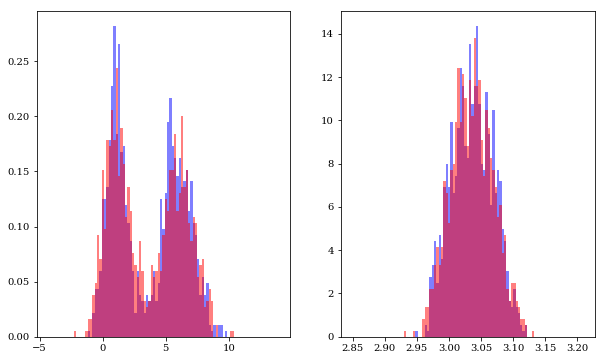

In [2]:
np.random.seed(9235)
NUM = 1000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges)
xc, yc = np.meshgrid(*cents)
grid = np.vstack([xc.ravel(), yc.ravel()])

bws = [0.5, 2.0]

kde2d = kale.KDE(data, bw_method=bws)

kde1d = [kale.KDE(dd, bw_method=ss) for dd, ss in zip(data, bws)]

fig, axes = plt.subplots(figsize=[10, 6], ncols=2)

for ii in range(2):
    samp_1d = kde1d[ii].resample(NUM).squeeze()
    samp_2d = kde2d.resample(NUM)[ii]

    ks, pv = sp.stats.ks_2samp(samp_1d, samp_2d)

    ax = axes[ii]
    for samp, cc in zip([samp_1d, samp_2d], ['b', 'r']):
        ax.hist(samp, bins=edges[ii], color=cc, density=True, alpha=0.5)    
    
plt.show()

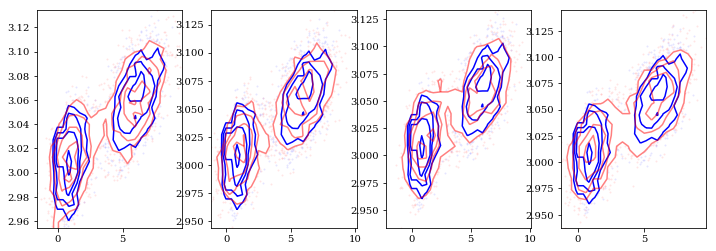

In [3]:
NUM = 2000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', 30, stretch=1.0) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges)
xc, yc = np.meshgrid(*cents)
grid = np.vstack([xc.ravel(), yc.ravel()])

ss = [0.5, 1.0]
t1 = np.einsum('i,j', ss, ss)
t2 = np.identity(len(ss)) * ss
bws = [0.2, t1, t2, (0.25, 2.)]
fig, axes = plt.subplots(figsize=[12, 4], ncols=len(bws))
levels = sp.stats.norm.cdf([-2, -1, 1, 2])

for ii, (ax, bw) in enumerate(zip(axes, bws)):
    hist, *_ = np.histogram2d(*data, bins=edges, density=True)
    corner.hist2d(*data, plot_density=False, ax=ax, color='blue')
    
    kde = kale.KDE(data, bw_method=bw)
    pdf = kde.pdf(grid).reshape(hist.shape).T
    samples = kde.resample(NUM)
    corner.hist2d(*samples, plot_density=False, ax=ax, color='red', contour_kwargs=dict(alpha=0.5))

    
plt.show()

## Keep Dimensions in Resample

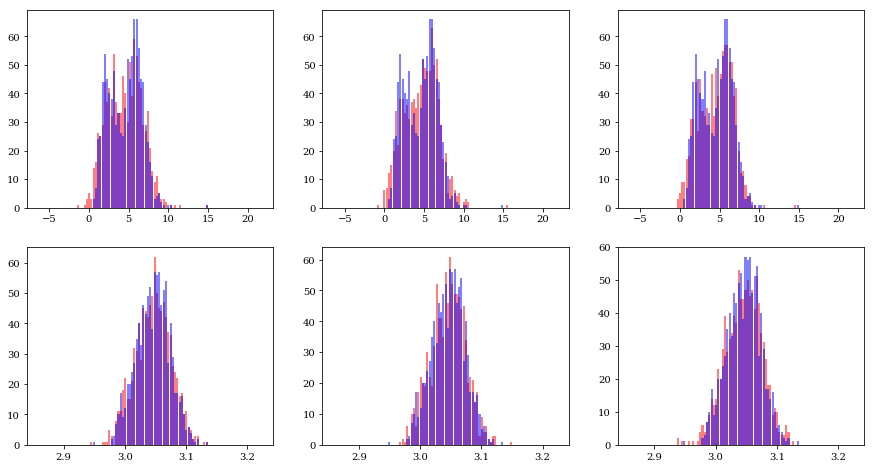

In [4]:
np.random.seed(9235)
NUM = 1000
a1 = np.random.normal(6.0, 1.0, NUM//2)
# a2 = np.random.lognormal(0, 0.5, size=NUM//2)
a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
kde2d = kale.KDE(data)


fig, axes = plt.subplots(figsize=[15, 8], nrows=2, ncols=3)

norm = 2.3

for ii in range(3):
    test = np.array(data)
    test = np.insert(test, ii, norm*np.ones_like(test[0]), axis=0)

    kde3d = kale.KDE(test)
    
    samples = kde3d.resample(NUM, keep=ii)
    param_samp = samples[ii]
    if not np.allclose(param_samp, norm):
        raise ValueError("Failure!")

    samples = np.delete(samples, ii, axis=0)
    
    for jj in range(2):
        ax = axes[jj, ii]
        stuff = [samples[jj], data[jj]]
        for vals, cc in zip(stuff, ['r', 'b']):
            ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

        ks, pv = sp.stats.ks_2samp(*stuff)
        msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
        # print(msg)
        # zplot.text(ax, msg, loc='ur')
    
plt.show()

In [5]:
# np.random.seed(2234)
# NUM = 300
# a1 = np.random.normal(6.0, 1.0, NUM//2)
# # a2 = np.random.lognormal(0, 0.5, size=NUM//2)
# a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
# aa = np.concatenate([a1, a2])

# bb = np.random.normal(3.0, 0.02, NUM) + aa/100

# data = [aa, bb]
# edges = [kale.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
# kde2d = kale.KDE(data)


# norms = [2.3, -3.4]

# pvals = []
# for ii in range(3):
#     # print("")
#     for jj in range(3):
#         if ii == jj:
#             continue
            
#         lo = np.min([ii, jj])
#         hi = np.max([ii, jj])
#         test = np.array(data)
#         test = np.insert(test, lo, norms[0]*np.ones_like(test[0]), axis=0)
#         test = np.insert(test, hi, norms[1]*np.ones_like(test[0]), axis=0)

#         kde4d = kale.KDE(test)

#         samples = kde4d.resample(NUM, keep=(lo, hi))
# #         for kk, samp in enumerate(samples):
# #             print(ii, jj, kk, zmath.stats_str(samp))
        
#         for kk, ll in enumerate([lo, hi]):
#             param_samps = samples[ll]
#             if not np.allclose(param_samps, norms[kk]):
#                 print(norms[kk], zmath.stats_str(param_samps))
#                 raise ValueError("Failure!")

#         samples = np.delete(samples, (lo, hi), axis=0)

#         for jj in range(2):
#             stuff = [samples[jj], data[jj]]
#             for vals, cc in zip(stuff, ['r', 'b']):
#                 ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

#             ks, pv = sp.stats.ks_2samp(*stuff)
#             msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
#             pvals.append(pv)
#             assert pv > 0.1, print(msg)
            
            
# print(np.min(pvals))
# print(pvals)


# Reflecting Boundaries

## PDF

### 1D

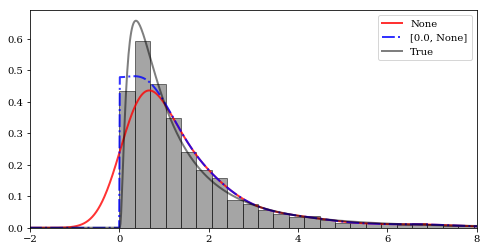

In [6]:
np.random.seed(5142)
NUM = 3000
aa = np.random.lognormal(size=NUM)
# aa = aa[aa < 10.0]

extr = [0.0, 10.0]
edges = kale.utils.spacing(extr, 'lin', 30)
grid = kale.utils.spacing(extr, 'lin', 1000, stretch=0.5)

fig, ax = plt.subplots(figsize=[8, 4])

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)


# boundaries = [None, [0.0], [2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
boundaries = [None, [0.0, None]]
lines = ['-', '-.']
colors = ['r', 'b']
pdf = sp.stats.lognorm(1.0).pdf(grid)
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kale.KDE(aa)
    ax.plot(grid, kde.pdf(grid, reflect=bnd), color=cc, ls=ls, lw=2.0, alpha=0.8, label=str(bnd))

ax.plot(grid, pdf, 'k-', label='True', alpha=0.5, lw=2.0)
    
ax.set_xlim([-2, 8])
plt.legend()
plt.show()

Total = 9.9999e-01
Total = 1.0001e+00
Total = 1.0001e+00
Total = 1.0003e+00


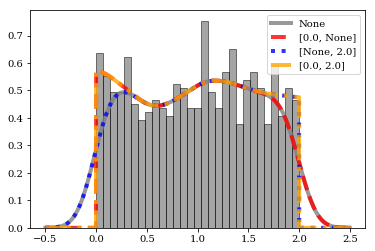

In [7]:
np.random.seed(124)
NUM = 1000
extr = [0.0, 2.0]
aa = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', 30)
egrid = kale.utils.spacing(extr, 'lin', 2000, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)
fig, ax = plt.subplots()

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)

boundaries = [None, [0.0, None], [None, 2.0], extr]
lines = ['-', '--', ':', '-.']
colors = ['0.5', 'red', 'blue', 'orange']
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kale.KDE(aa)
    pdf = kde.pdf(cgrid, reflect=bnd)
    ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
    
    tot = np.sum(pdf * delta)
    print("Total = {:.4e}".format(tot))
    assert np.isclose(tot, 1.0, rtol=1e-2), "Unitarity is violated!"
    
plt.legend()
plt.show()

In [8]:
# np.random.seed(124)
# NUM = 1000
# extr = [0.0, 2.0]
# aa = np.random.uniform(*extr, NUM)

# edges = kale.utils.spacing(extr, 'lin', 14)
# egrid = kale.utils.spacing(extr, 'lin', 1000, stretch=0.5)
# cgrid = kale.utils.midpoints(egrid, 'lin')
# delta = np.diff(egrid)
# fig, ax = plt.subplots(figsize=[10, 8])



# ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)
# for dd in aa:
#     l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)


# boundaries = [None, [0.0, None], [None, 2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
# colors = ['0.5', 'red', 'blue', 'orange']
# for bnd, cc, ls in zip(boundaries, colors, lines):
#     kde = kale.KDE(aa, kernel=kale.kernels.Box, bandwidth=2.0)
#     pdf = kde.pdf(cgrid, reflect=bnd)
#     ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
#     tot = np.sum(pdf * delta)
#     print("Total: {:.4e}".format(tot))
    
# plt.legend()
# plt.show()

### 2D

No handles with labels found to put in legend.


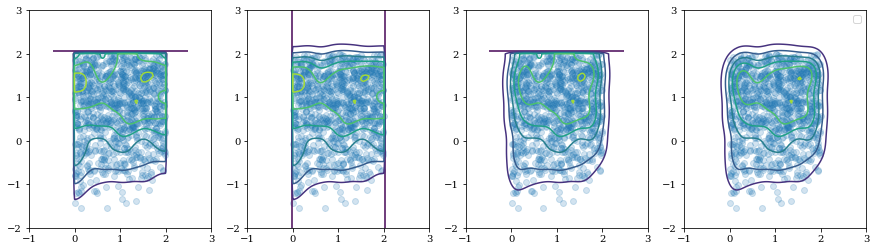

In [9]:
np.random.seed(124)
NUM = 1000
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.0, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])

data = [xx, yy]
edges = [kale.utils.spacing(aa, 'lin', 30) for aa in [xx, yy]]
egrid = [kale.utils.spacing(ee, 'lin', 100, stretch=0.5) for ee in edges]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid)

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[15, 4], ncols=4)

for ax in axes:
    ax.scatter(xx, yy, alpha=0.2)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)


kde = kale.KDE(data)
reflect = [[0.0, 2.0], [None, 2.0]]
pdf_1d = kde.pdf(grid, reflect=reflect)
pdf = pdf_1d.reshape(hist.shape)
# ax.contour(*cgrid, pdf)

inside = True
outside = True
for ii, ref in enumerate(reflect):
    if ref[0] is None:
        ref[0] = -np.inf
    if ref[1] is None:
        ref[1] = np.inf
    inside = inside & (ref[0] < grid[ii]) & (grid[ii] < ref[1])
    outside = outside & ((grid[ii] < ref[0]) | (ref[1] < grid[ii]))
    
assert np.all(pdf_1d[inside] > 0.0), "Inside has zero values!"
assert np.allclose(pdf_1d[outside], 0.0), "Outside has non-zero values!"

area = width[0][:, np.newaxis] * width[1][np.newaxis, :]
prob_tot = np.sum(pdf * area)
assert np.isclose(prob_tot, 1.0, rtol=3e-2), "`prob_tot` = '{}' is not unity!".format(prob_tot)
    
# ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)
# 
# boundaries = [None, [0.0, None], [None, 2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
# colors = ['0.5', 'red', 'blue', 'orange']
# for bnd, cc, ls in zip(boundaries, colors, lines):
#     kde = kdes.KDE(aa)
#     pdf = kde.pdf(cgrid, reflect=bnd)
#     ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
    
reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
for ii, ax in enumerate(axes):
    pdf_1d = kde.pdf(grid, reflect=reflections[ii])
    pdf = pdf_1d.reshape(hist.shape)
    ax.contour(*cgrid, pdf)
    
    ax.set(xlim=[-1.0, 3.0], ylim=[-2, 3])

plt.legend()
plt.show()

## Resampling

### 1D

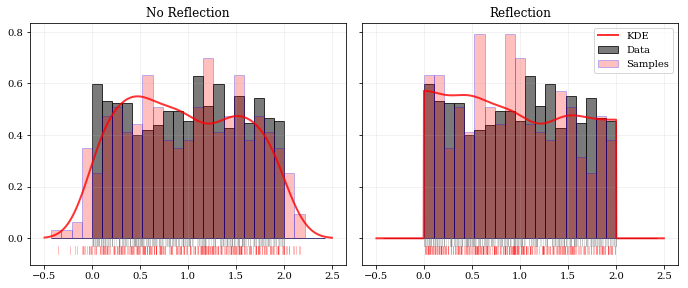

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_1d_reflect.png'


In [10]:
np.random.seed(1245)
NUM = 300

extr = [0.0, 2.0]
data = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', 20)
edges = np.concatenate([
    edges[0] - np.arange(1, 5)[::-1]*np.diff(edges)[0],
    edges,
    edges[-1] + np.arange(1, 5)*np.diff(edges)[-1],
])

egrid = kale.utils.spacing(data, 'lin', 1000, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)

fig, axes = plt.subplots(figsize=[10, 4], ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

kde = kale.KDE(data)

reflections = [None, extr]
titles = ['No Reflection', 'Reflection']
for ii, reflect in enumerate(reflections):
    ax = axes[ii]
    ax.grid(alpha=0.2)
    ax.set_title(titles[ii])
    *_, l0 = ax.hist(aa, bins=edges, alpha=0.75, color='0.3', edgecolor='k', density=True)
    pdf = kde.pdf(cgrid, reflect=reflect)
    l1, = ax.plot(cgrid, pdf, color='r', ls='-', lw=2.0, alpha=0.8)
    for dd in data:
        l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)
    
    samp = kde.resample(NUM, reflect=reflect)
    *_, l3 = ax.hist(samp, bins=edges, alpha=0.25, color='r', edgecolor='b', density=True)
    for ss in samp:
        l4, = ax.plot([ss, ss], [-0.03, -0.06], color='r', alpha=0.5, lw=0.5)
    
    some_outside = np.any((samp < extr[0]) + (extr[1] < samp))
    if reflect is None:
        assert some_outside, "There should be some samples outside!"
    else:
        assert (not some_outside), "There should not be any samples outside!"
        ks, pv = sp.stats.ks_2samp(data, samp)
        assert (pv > 0.4), "New sample is inconsistent!"
        
lines = [l1, l0[0], l3[0]]
names = ['KDE', 'Data', 'Samples']
plt.legend(lines, names)
plt.show()

fname = 'kde_1d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

### 2D

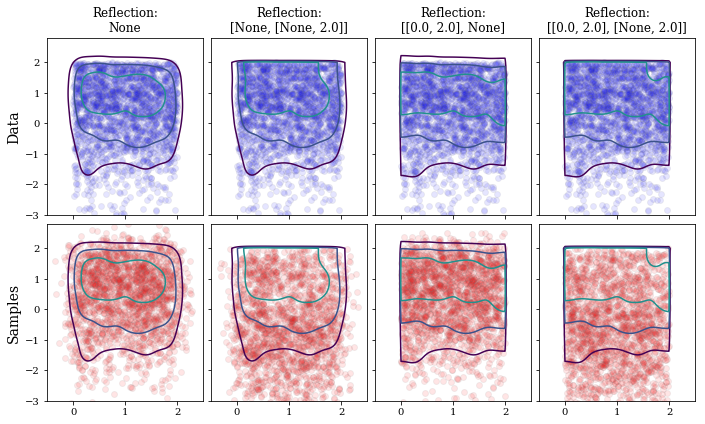

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_2d_reflect.png'


In [11]:
seed = np.random.randint(int(1e4))
seed = 8067
# print(seed)
np.random.seed(seed)
NUM = 2000
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.5, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])

data = [xx, yy]
edges = [kale.utils.spacing(aa, 'lin', 30) for aa in [xx, yy]]
egrid = [kale.utils.spacing(ee, 'lin', 100, stretch=0.5) for ee in edges]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid)

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[10, 6], ncols=4, nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)

levels = [0.05, 0.1, 0.15, 0.2, 0.25]

kde = kale.KDE(data)

reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
kw = dict(edgecolor='0.5', alpha=0.1)
fs = 14
for ii, (axcol, reflect) in enumerate(zip(axes.T, reflections[::-1])):
    title = "Reflection:\n" + str(reflect)
    ylab = None
    pdf_1d = kde.pdf(grid, reflect=reflect)
    pdf = pdf_1d.reshape(hist.shape)
    uu, vv = kde.resample(reflect=reflect)
    for jj, ax in enumerate(axcol):
        if jj == 0:
            if ii == 0:
               ylab = 'Data'                 
            ax.scatter(xx, yy, facecolor='b', **kw)
            ax.set_title(title)
        else:
            if ii == 0:
               ylab = 'Samples'                 
            ax.scatter(uu, vv, facecolor='r', **kw)

        ax.contour(*cgrid, pdf, zorder=10, levels=levels)
        ax.set(xlim=[-0.5, 2.5], ylim=[-3, 2.8])
        ax.set_ylabel(ylab, size=fs)
        
plt.show()

fname = 'kde_2d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

# Other Kernels

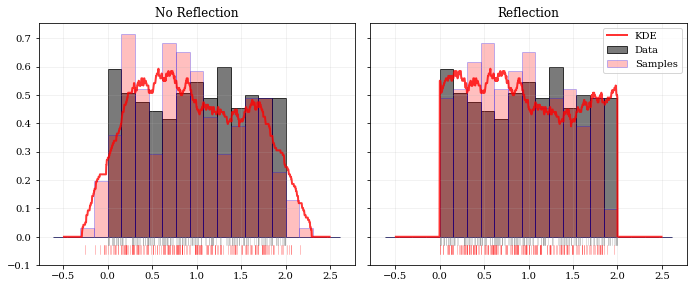

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_1d_reflect.png'


In [13]:
np.random.seed(1245)
NUM = 200

extr = [0.0, 2.0]
data = np.random.uniform(*extr, NUM)

edges = kale.utils.spacing(extr, 'lin', 14)
edges = np.concatenate([
    edges[0] - np.arange(1, 5)[::-1]*np.diff(edges)[0],
    edges,
    edges[-1] + np.arange(1, 5)*np.diff(edges)[-1],
])

egrid = kale.utils.spacing(data, 'lin', 1000, stretch=0.5)
cgrid = kale.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)

fig, axes = plt.subplots(figsize=[10, 4], ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

kde = kale.KDE(data, kernel=kale.kernels.Box_Asym, bandwidth=0.5)

reflections = [None, extr]
titles = ['No Reflection', 'Reflection']
for ii, reflect in enumerate(reflections):
    ax = axes[ii]
    ax.grid(alpha=0.2)
    ax.set_title(titles[ii])
    *_, l0 = ax.hist(aa, bins=edges, alpha=0.75, color='0.3', edgecolor='k', density=True)
    pdf = kde.pdf(cgrid, reflect=reflect)
    l1, = ax.plot(cgrid, pdf, color='r', ls='-', lw=2.0, alpha=0.8)
    for dd in data:
        l2, = ax.plot([dd, dd], [0.0, -0.03], color='0.5', alpha=0.5, lw=0.5)
    
    tot = np.sum(pdf*delta)
    
    samp = kde.resample(NUM, reflect=reflect)
    *_, l3 = ax.hist(samp, bins=edges, alpha=0.25, color='r', edgecolor='b', density=True)
    for ss in samp:
        l4, = ax.plot([ss, ss], [-0.03, -0.06], color='r', alpha=0.5, lw=0.5)
    
    some_outside = np.any((samp < extr[0]) + (extr[1] < samp))
    if reflect is None:
        assert some_outside, "There should be some samples outside!"
    else:
        assert (not some_outside), "There should not be any samples outside!"
        ks, pv = sp.stats.ks_2samp(data, samp)
        assert (pv > 0.4), "New sample is inconsistent!"

    assert np.isclose(tot, 1.0, rtol=1e-2), "Unitarity violated!  Prob tot: {:.4e}".format(tot)

lines = [l1, l0[0], l3[0]]
names = ['KDE', 'Data', 'Samples']
plt.legend(lines, names)
plt.show()

fname = 'kde_1d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

reflect: None, inside: [0.00e+00, 0.00e+00, 0.00e+00, 4.01e-03, 6.82e-02, 1.64e-01, 2.25e-01]
1 None prob_tot = 1.0012e+00
	 [0.00e+00, 0.00e+00, 0.00e+00, 4.01e-03, 6.82e-02, 1.64e-01, 2.25e-01]
reflect: [None, [-inf, 2.0]], inside: [0.00e+00, 0.00e+00, 0.00e+00, 8.02e-03, 1.00e-01, 1.68e-01, 2.25e-01]
1 [None, [-inf, 2.0]] prob_tot = 1.0140e+00
	 [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.82e-02, 1.64e-01, 2.25e-01]
reflect: [[0.0, 2.0], None], inside: [0.00e+00, 0.00e+00, 0.00e+00, 2.41e-02, 1.24e-01, 1.72e-01, 2.49e-01]
1 [[0.0, 2.0], None] prob_tot = 1.0145e+00
	 [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 7.22e-02, 1.64e-01, 2.49e-01]
reflect: [[0.0, 2.0], [-inf, 2.0]], inside: [0.00e+00, 0.00e+00, 0.00e+00, 4.81e-02, 1.44e-01, 1.81e-01, 2.49e-01]
1 [[0.0, 2.0], [-inf, 2.0]] prob_tot = 1.0270e+00
	 [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 7.62e-02, 1.68e-01, 2.49e-01]


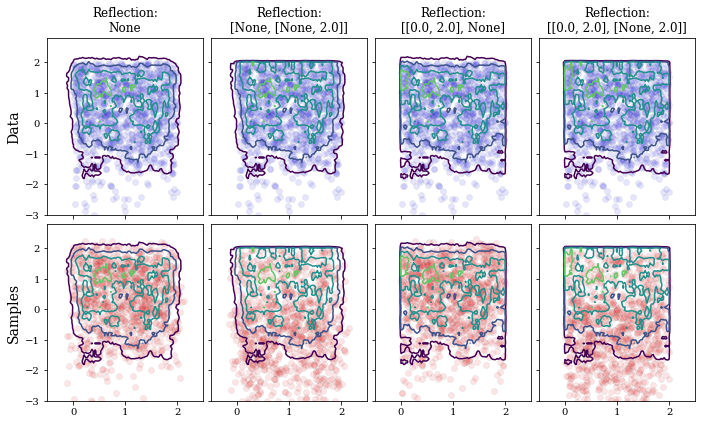

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/kde_2d_reflect.png'


In [14]:
seed = np.random.randint(int(1e4))
seed = 8067
# print(seed)
np.random.seed(seed)
NUM = 1000
xx = np.random.uniform(0.0, 2.0, NUM)
yy = np.random.normal(1.0, 1.5, NUM)
yy = yy[yy < 2.0]
yy = np.concatenate([yy, np.random.choice(yy, NUM-yy.size)])

data = [xx, yy]
edges = [kale.utils.spacing(aa, 'lin', 30) for aa in [xx, yy]]
egrid = [kale.utils.spacing(ee, 'lin', 100, stretch=0.5) for ee in edges]
cgrid = [kale.utils.midpoints(ee, 'lin') for ee in egrid]
width = [np.diff(ee) for ee in egrid]

xc, yc = np.meshgrid(*cgrid)

grid = np.vstack([xc.ravel(), yc.ravel()])

fig, axes = plt.subplots(figsize=[10, 6], ncols=4, nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05, left=0.08, right=0.98, bottom=0.08, top=0.92)

hist, *_ = np.histogram2d(*data, bins=egrid, density=True)

levels = [0.05, 0.1, 0.15, 0.2, 0.25]

kde = kale.KDE(data, kernel='box')
inside_test_func = np.all if not kde.kernel.FINITE else np.any

reflections = [
    [[0.0, 2.0], [None, 2.0]],
    [[0.0, 2.0], None],
    [None, [None, 2.0]],
    None
]
kw = dict(edgecolor='0.5', alpha=0.1)
fs = 14
for ii, (axcol, reflect) in enumerate(zip(axes.T, reflections[::-1])):
    title = "Reflection:\n" + str(reflect)
    ylab = None
    pdf_1d = kde.pdf(grid, reflect=reflect)
    pdf = pdf_1d.reshape(hist.shape)
    uu, vv = kde.resample(reflect=reflect)
    for jj, ax in enumerate(axcol):
        if jj == 0:
            if ii == 0:
               ylab = 'Data'                 
            ax.scatter(xx, yy, facecolor='b', **kw)
            ax.set_title(title)
        else:
            if ii == 0:
               ylab = 'Samples'                 
            ax.scatter(uu, vv, facecolor='r', **kw)

        ax.contour(*cgrid, pdf, zorder=10, levels=levels)
        ax.set(xlim=[-0.5, 2.5], ylim=[-3, 2.8])
        ax.set_ylabel(ylab, size=fs)
        
    inside = np.ones_like(pdf_1d, dtype=bool)
    if reflect is None:
        outside = np.zeros_like(pdf_1d, dtype=bool)
    else:
        outside = np.ones_like(pdf_1d, dtype=bool)
        for ii, ref in enumerate(reflect):
            if ref is None:
                ref = [-np.inf, np.inf]
            if ref[0] is None:
                ref[0] = -np.inf
            if ref[1] is None:
                ref[1] = np.inf
            inside = inside & (ref[0] < grid[ii]) & (grid[ii] < ref[1])
            outside = outside & ((grid[ii] < ref[0]) | (ref[1] < grid[ii]))

    print("reflect: {}, inside: {}".format(reflect, kale.utils.stats_str(pdf_1d[inside])))
    assert_true(inside_test_func(pdf_1d[inside] > 0.0))
    assert_true(np.allclose(pdf_1d[outside], 0.0))

    area = width[0][:, np.newaxis] * width[1][np.newaxis, :]
    prob_tot = np.sum(pdf * area)
    print(jj, reflect, "prob_tot = {:.4e}".format(prob_tot))
    print("\t", kale.utils.stats_str(pdf))
    assert_true(np.isclose(prob_tot, 1.0, rtol=3e-2))
        

plt.show()

fname = 'kde_2d_reflect.png'
fname = os.path.abspath(fname)
fig.savefig(fname)
print("Saved to '{}'".format(fname))

# Other